In [1]:
import numpy as np
import MyML.EAC.full as myEacFull
import MyML.EAC.sparse as myEacSp
import MyML.EAC.eac as myEac
import MyML.EAC.eac_new as myNewEac
import MyML.cluster.K_Means3 as myKM
import MyML.helper.partition as myEacPart
import MyML.metrics.accuracy as myAcc

import matplotlib.pyplot as plt
%matplotlib inline

/home/chiroptera/anaconda/lib/python2.7/site-packages/numba/cuda/decorators.py:106: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


In [84]:
reload(myEacFull)
reload(myEacPart)
reload(myEacSp)
reload(myEac)
reload(myNewEac)

<module 'MyML.EAC.eac_new' from '/home/chiroptera/workspace/QCThesis/MyML/EAC/eac_new.py'>

CPU times: user 35 µs, sys: 3 µs, total: 38 µs
Wall time: 42.9 µs
CPU times: user 1.96 s, sys: 218 ms, total: 2.18 s
Wall time: 2.18 s


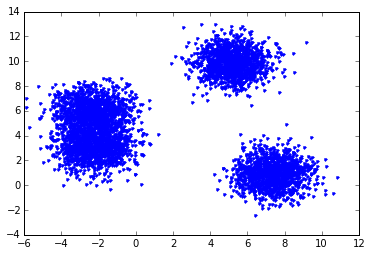

In [97]:
from sklearn.datasets import make_blobs

n_samples = 5000
data,gt = make_blobs(n_samples, centers=4)
%time data = data.astype(np.float32)

plt.plot(data[:,0], data[:,1], '.')

generator = myKM.K_Means()
generator._MAX_THREADS_BLOCK = 256
%time ensemble = myEacPart.generateEnsemble(data, generator, n_clusters=[25,100],npartitions=100)

In [98]:
%time fullEAC = myNewEac.EAC(n_samples, sparse=False, condensed=True)
%time fullEAC.buildMatrix(ensemble)

%time spEAC = myNewEac.EAC(n_samples, sparse=True, condensed=True, sparse_keep_degree=True)
%time spEAC.buildMatrix(ensemble)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 51 µs
CPU times: user 362 ms, sys: 11.3 ms, total: 373 ms
Wall time: 370 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 25 µs
CPU times: user 3.18 s, sys: 15.9 ms, total: 3.2 s
Wall time: 3.19 s


In [99]:
%time fullEAC.finalClustering(n_clusters=0) 
%time spEAC.finalClustering(n_clusters=0)
# b MyML/EAC/eac_new.py:606
# b MyML/EAC/eac_new.py:556

CPU times: user 488 ms, sys: 44.3 ms, total: 532 ms
Wall time: 532 ms
CPU times: user 294 ms, sys: 0 ns, total: 294 ms
Wall time: 293 ms


array([0, 1, 1, ..., 2, 0, 1], dtype=int32)

full bincount [1250 1250 2500]
full bincount [1250 2500 1250]


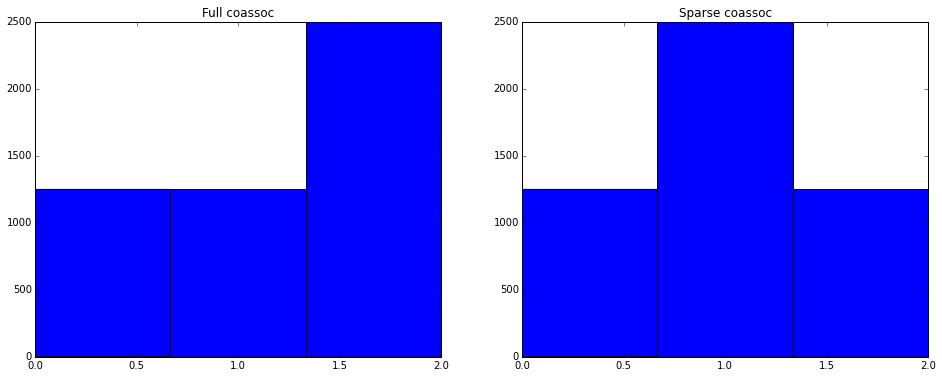

In [100]:
histFig = plt.figure(figsize=(16,6))

ax = histFig.add_subplot(1,2,1)
ax.hist(fullEAC.labels,bins=fullEAC.n_fclusts)
ax.set_title("Full coassoc")
print "full bincount", np.bincount(fullEAC.labels)

ax = histFig.add_subplot(1,2,2)
ax.hist(spEAC.labels,bins=spEAC.n_fclusts)
ax.set_title("Sparse coassoc")
print "full bincount", np.bincount(spEAC.labels)

In [101]:
acc = myAcc.HungarianIndex(n_samples)
acc.score(gt, fullEAC.labels)
acc.accuracy

0.75

In [102]:
acc = myAcc.HungarianIndex(n_samples)
acc.score(gt, spEAC.labels)
acc.accuracy

0.0

In [103]:
acc2 = myAcc.ConsistencyIndex(N=n_samples)
acc2.score(gt, fullEAC.labels)

0.75

In [104]:
acc2 = myAcc.ConsistencyIndex(N=n_samples)
acc2.score(gt, spEAC.labels)

0.75

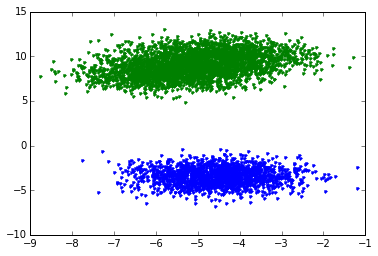

In [36]:
for c in xrange(fullEAC.n_fclusts):
    c_idx = fullEAC.labels == c
    plt.plot(data[c_idx,0], data[c_idx,1], '.')

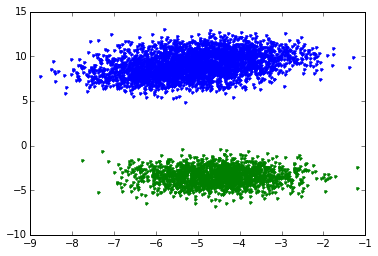

In [37]:
for c in xrange(spEAC.n_fclusts):
    c_idx = spEAC.labels == c
    plt.plot(data[c_idx,0], data[c_idx,1], '.')

In [20]:
(fullEAC.coassoc.todense() == (spEAC.coassoc.todense() + spEAC.coassoc.todense().T)).all()

True

In [65]:
max_assocs

876

In [64]:
spEAC.coassoc.max_assocs

876

In [14]:
%time full = myEacFull.EAC_FULL(n_samples, condensed=False)
%time full.update_ensemble(ensemble)

CPU times: user 1.57 ms, sys: 70 µs, total: 1.64 ms
Wall time: 872 µs
CPU times: user 274 ms, sys: 3.84 ms, total: 278 ms
Wall time: 279 ms


In [15]:
%time cfull = myEacFull.EAC_FULL(n_samples, condensed=True)
%time cfull.update_ensemble(ensemble)

CPU times: user 683 µs, sys: 30 µs, total: 713 µs
Wall time: 472 µs
CPU times: user 69.2 ms, sys: 23 µs, total: 69.2 ms
Wall time: 67.1 ms


In [16]:
(full.coassoc == cfull.todense() + ).all()

True

In [17]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time sp = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=False, sort_mode="numpy")
%time sp.update_ensemble(ensemble)

CPU times: user 141 µs, sys: 6 µs, total: 147 µs
Wall time: 131 µs
CPU times: user 3.28 s, sys: 11.3 ms, total: 3.29 s
Wall time: 3.28 s


In [18]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time sp2 = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=False, sort_mode="surgical")
%time sp2.update_ensemble(ensemble)

CPU times: user 146 µs, sys: 6 µs, total: 152 µs
Wall time: 136 µs
CPU times: user 1.24 s, sys: 16.2 ms, total: 1.26 s
Wall time: 1.24 s


In [21]:
sp._condense(keep_degree=True)
sp2._condense(keep_degree=True)
print (sp.todense() == sp2.todense()).all()
print (sp.todense() == full.coassoc).all()

True
True


In [22]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=True, sort_mode="numpy")
%time csp.update_ensemble(ensemble)

CPU times: user 269 µs, sys: 10 µs, total: 279 µs
Wall time: 223 µs
CPU times: user 2.31 s, sys: 3.76 ms, total: 2.31 s
Wall time: 2.3 s


In [23]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp2 = myEacSp.EAC_CSR(n_samples, max_assocs, condensed=True, sort_mode="surgical")
%time csp2.update_ensemble(ensemble)

CPU times: user 140 µs, sys: 4 µs, total: 144 µs
Wall time: 131 µs
CPU times: user 513 ms, sys: 8.18 ms, total: 521 ms
Wall time: 510 ms


In [24]:
csp._condense(keep_degree=True)
csp2._condense(keep_degree=True)

print "condensed numpy", ((csp.todense() + csp.todense().T) == full.coassoc).all()
print "condensed surgical", ((csp2.todense() + csp2.todense().T) == full.coassoc).all()

condensed numpy True
condensed surgical True


In [25]:
max_assocs = myEacSp._compute_max_assocs_from_ensemble(ensemble) * 3
%time csp2 = myEacSp.EAC_CSR(n_samples, max_assocs, max_assocs_type='linear', condensed=True, sort_mode="surgical")
%time csp2.update_ensemble(ensemble)

CPU times: user 0 ns, sys: 3.91 ms, total: 3.91 ms
Wall time: 270 µs
CPU times: user 455 ms, sys: 4.12 ms, total: 459 ms
Wall time: 455 ms


In [26]:
csp2._condense(keep_degree=True)

In [27]:
print "condensed surgical", ((csp2.todense() + csp2.todense().T) == full.coassoc).all()

condensed surgical True


# Linkage sparse

In [62]:
import scipy.sparse.csgraph as csgraph

In [65]:
reload(csgraph)

<module 'scipy.sparse.csgraph' from '/home/chiroptera/anaconda/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.pyc'>

In [201]:
coassoc = csp2.csr.copy()
coassoc.data = coassoc.data.max() + 1 - coassoc.data

In [202]:
mst.indptr

array([   0,    2,    4, ..., 1997, 1997, 1997], dtype=int32)

(array([   0.,   35.,   52.,   73.,   81.,  109.,  131.,  120.,  125.,
         119.,  121.,   95.,  110.,  113.,  103.,   88.,   87.,   59.,
          61.,   75.,   54.,   39.,   34.,   28.,   35.,   14.,   15.,
           9.,    4.,    2.,    1.,    1.,    2.,    1.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.]),
 array([   0.        ,    0.99019608,    1.98039216,    2.97058824,
           3.96078431,    4.95098039,    5.94117647,    6.93137255,
           7.92156863,    8.91176471,    9.90196078,

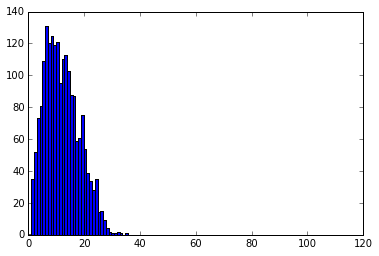

In [203]:
mst = csgraph._min_spanning_tree.minimum_spanning_tree(coassoc).astype(np.uint8)

plt.hist(mst.data, bins=102, range=(0,101))

In [131]:
# inputs
n_clusters = 4
n_partitions = 100

In [132]:
# converting to diassociations
coassoc.data = coassoc.data.max() + 1 - coassoc.data

# get minimum spanning tree
mst = csgraph.minimum_spanning_tree(coassoc).astype(np.uint8)

# compute number of disconnected components
n_disconnect_clusters = mst.shape[0] - mst.nnz

# sort associations by weights
asort = mst.data.argsort()
sorted_weights = mst.data[asort]

if n_clusters == 0:
    # compute lifetimes
    lifetimes = sorted_weights[1:] - sorted_weights[:-1]

    # add 1 to n_partitions as the maximum weight because I also added
    # 1 when converting to diassoc to avoid having zero weights
    disconnect_lifetime = n_partitions + 1 - sorted_weights[-1]

    # maximum lifetime
    m_index = np.argmax(lifetimes)
    th = lifetimes[m_index]

    # get number of clusters from lifetimes
    indices = np.where(mst.data > mst.data[m_index])[0]
    if indices.size == 0:
        cont = 1
    else:
        cont = indices.size + 1

    #testing the situation when only 1 cluster is present
    # if maximum lifetime is smaller than 2 times the minimum
    # don't make any cuts (= 1 cluster)
    # max>2*min_interval -> nc=1
    close_to_zero_indices = np.where(np.isclose(lifetimes, 0))
    minimum = np.min(lifetimes[close_to_zero_indices])

    if th < 2 * minimum:
        cont = 1

    # add disconnected clusters to number of clusters if disconnected
    # lifetime is smaller
    if th > disconnect_lifetime:
        cont += n_disconnect_clusters
    else:
        cont = n_disconnect_clusters

    nc_stable = cont
else:
    nc_stable = n_clusters

  
    
n_comps, labels = csgraph.connected_components(mst)

4 [0 1 0 ..., 2 1 1]


(array([ 667.,  666.,  666.,    1.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ]),
 <a list of 4 Patch objects>)

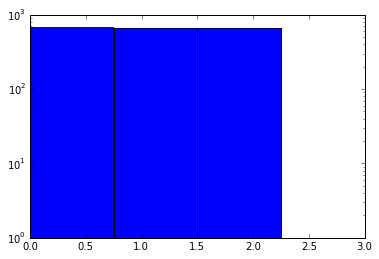

In [133]:
print n_comps, labels
plt.hist(labels, bins=n_comps, log=True)

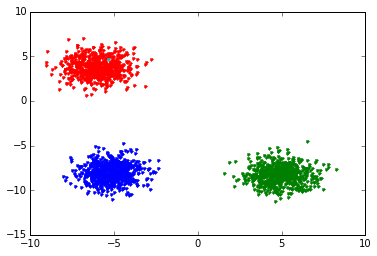

In [134]:
for c in xrange(n_comps):
    c_idx = labels == c
    plt.plot(data[c_idx,0],data[c_idx,1],'.')

In [33]:
nc_stable

3

In [66]:
nc_stable

2

In [ ]:
        if n_clusters == 0:
            # lifetime is here computed as the distance difference between 
            # any two consecutive nodes, i.e. the distance between passing
            # from n to n-1 clusters

            lifetimes = Z[1:,2] - Z[:-1,2]

            m_index = np.argmax(lifetimes)

            # Z is ordered in increasing order by weight of connection
            # the connection whose weight is higher than the one specified
            # by m_index MUST be the one from which the jump originated the
            # maximum lifetime; all connections above that (and including)
            # will be removed for the final clustering
            indices = np.where(Z[:,2] > Z[m_index, 2])[0]
            #indices = np.arange(m_index+1, Z.shape[0])
            if indices.size == 0:
                cont = 1
            else:
                cont = indices.size + 1

            # store maximum lifetime
            th = lifetimes[m_index]

            #testing the situation when only 1 cluster is present
            # if maximum lifetime is smaller than 2 times the minimum
            # don't make any cuts (= 1 cluster)
            #max>2*min_interval -> nc=1
            close_to_zero_indices = np.where(np.isclose(lifetimes, 0))
            minimum = np.min(lifetimes[close_to_zero_indices])

            if th < 2 * minimum:
                cont = 1

            nc_stable = cont

        else:
            nc_stable = n_clusters

        if nc_stable > 1:
            # only the labels are of interest

            labels = labels_from_Z(Z, n_clusters=nc_stable)

            # rename labels
            i=0
            for l in np.unique(labels):
                labels[labels == l] = i
                i += 1
        else:
            labels = np.zeros(self.n_samples, dtype = np.int32)

        self.labels_ = labels
        return labels

# linkage full

In [159]:
from scipy.cluster.hierarchy import linkage

In [204]:
coassoc = cfull.coassoc.copy()

In [207]:
myEac.make_diassoc_1d(coassoc, n_partitions)

# apply linkage
%time Z = myEac.linkage(coassoc, method="average")

CPU times: user 3.01 s, sys: 9.12 ms, total: 3.02 s
Wall time: 3.03 s


In [208]:
Z

array([[  3.10000000e+01,   2.06000000e+02,   1.00000000e+00,
          2.00000000e+00],
       [  2.31000000e+02,   9.47000000e+02,   1.00000000e+00,
          2.00000000e+00],
       [  2.55000000e+02,   1.66400000e+03,   1.00000000e+00,
          2.00000000e+00],
       ..., 
       [  3.98900000e+03,   3.99300000e+03,   9.96209231e+01,
          6.67000000e+02],
       [  3.99400000e+03,   3.99600000e+03,   1.01000000e+02,
          1.33400000e+03],
       [  3.99500000e+03,   3.99700000e+03,   1.01000000e+02,
          2.00000000e+03]])

In [185]:
labels = myEac.labels_from_Z(Z, n_clusters=100)
# rename labels
i=0
for l in np.unique(labels):
    labels[labels == l] = i
    i += 1

(array([ 35.,   0.,   0., ...,   0.,   0.,   2.]),
 array([   1.        ,    1.05002501,    1.10005003, ...,  100.89994997,
         100.94997499,  101.        ]),
 <a list of 1999 Patch objects>)

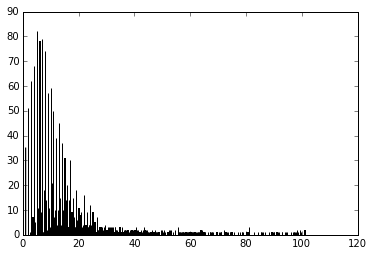

In [209]:
plt.hist(Z[:,2], bins=Z.shape[0])

[98 95 63 ..., 71 95 82]


(array([   1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,    1.,
           1.,    1.,    1.,    1.,    1.,    1.,    2.,    3.,    2.,
           3.,    3.,    2.,    2.,    2.,   12.,    2.,    2.,    4.,
           4.,    3.,    3.,    6.,    9.,    2.,    4.,    2.,   15.,
          20.,    7.,    3.,   41.,    3.,   15.,    3.,   17.,   25.,
          39.,    7.,   39.,   14.,   42.,   50.,    4.,    2.,    7.,
          51.,   45.,    7.,    5.,   14.,    7.,   49.,  260.,   51.,
          57.,   47.,   47.,   45.,    4.,  394.,   74.,    3.,  191.,  182.]),
 array([  0.  ,   0.99,   1.98,   2.97,   3.96,   4.95,   5.94,   6.93,
          7.92,   8.91,   9.9 ,  10.89,  11.88,  12.87,  13.86,  14.85,
         15.84,  16.83,  17.82,  18.81,  19.8 ,  20.79,  21.78,  2

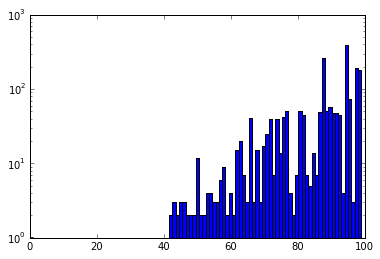

In [186]:
print labels
plt.hist(labels, bins=100, log=True)

# plot stuff

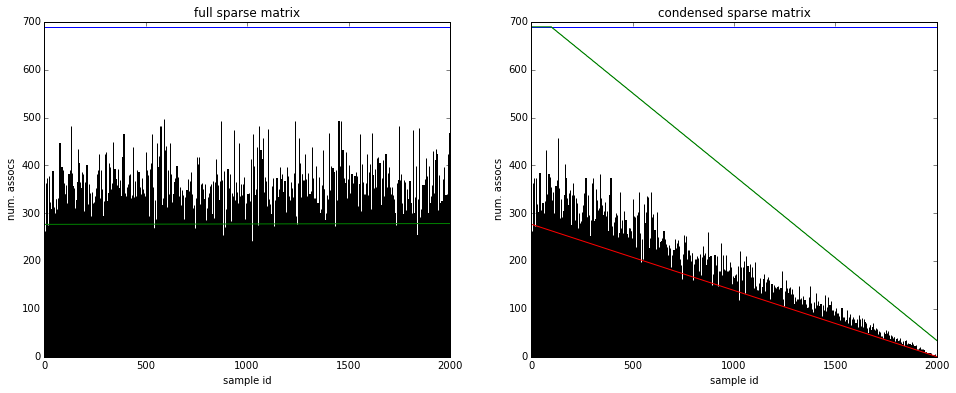

In [60]:
fig = plt.figure(figsize=(16,6))

x=np.arange(n_samples)

ax = fig.add_subplot(1,2,1)
ax.bar(x, sp.degree[:-1])
ax.plot([0,n_samples],[max_assocs, max_assocs])
fit = np.polyfit(x,sp.degree[:-1],1) # linear regression of degree
fit_fn = np.poly1d(fit) 
ax.plot(x, fit_fn(x))

ax.set_title("full sparse matrix")
ax.set_xlabel("sample id")
ax.set_ylabel("num. assocs")

ax = fig.add_subplot(1,2,2)
ax.bar(x, csp.degree[:-1]) # plot degree
ax.plot([0,n_samples],[max_assocs, max_assocs]) # plot max_assocs alloc

allocated_degree = csp2.indptr[1:] - csp2.indptr[:-1] # plot linear assoc
ax.plot(np.arange(sp.n_samples),allocated_degree)

fit = np.polyfit(x,csp.degree[:-1],1) # linear regression of degree
fit_fn = np.poly1d(fit) 
ax.plot(x, fit_fn(x))

ax.set_title("condensed sparse matrix")
ax.set_xlabel("sample id")
ax.set_ylabel("num. assocs")

In [58]:
fit_fn(x)

array([ 275.99378433,  275.85922344,  275.7246586 , ...,   -0.57809155,
         -0.72052195,   -0.8629563 ])

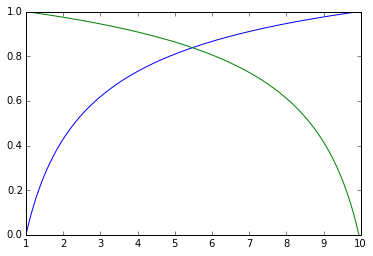

In [54]:
x = np.arange(1,10,0.05)
y = 1 / np.sqrt(x)
y = y.max() -y
y = y / y.max()
plt.plot(x,y)
plt.plot(x,y[::-1])
#plt.plot(x,np.sqrt(x)[::-1]/np.sqrt(x).max())

In [52]:
y.sum()

136.40980611903461

/home/chiroptera/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


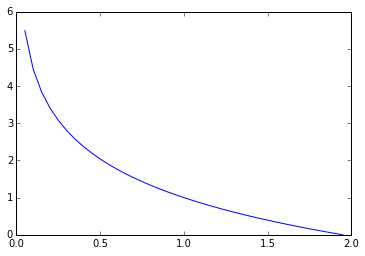

In [15]:
x = np.arange(0,2,0.05)
y = np.exp(x)
y /= y.max()
y = 1-y
plt.plot(x,y)

In [57]:
reload(myEacSp)

<module 'MyML.utils.sparse' from '/home/chiroptera/workspace/QCThesis/MyML/utils/sparse.pyc'>

In [60]:
y, y_sum = myEacSp.linear(n_samples, max_assocs, 0.1, 1, 1, 0.02)

In [61]:
total_area = n_samples * max_assocs
y_sum * 1.0 / total_area

0.55873891547049437

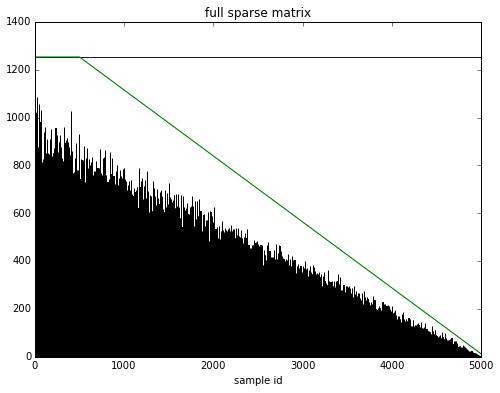

In [13]:
fig = plt.figure(figsize=(8,6))
x = np.arange(n_samples)
ax = fig.add_subplot(1,1,1)
ax.bar(x, csp.degree[:-1])
ax.plot([0,n_samples],[max_assocs, max_assocs])
#ax.plot(np.arange(n_samples), max_assoc_scheme)
ax.plot(x,y)

ax.set_title("full sparse matrix")
ax.set_xlabel("sample id")

In [67]:
import MyML.helper.scan as myScan
reload(myScan)

<module 'MyML.helper.scan' from '/home/chiroptera/workspace/QCThesis/MyML/helper/scan.py'>

In [63]:
y_c = y.copy()

In [71]:
y_sum

3503293

In [72]:
y_c

array([1254, 1254, 1254, ...,   25,   25, 5000], dtype=int32)

In [68]:
myScan.exprefixsumNumbaSingle(y)

3508293

In [77]:
class testme:
    def __init__(self,**kwargs):
        self.val2=kwargs.get("val2", 50)

In [80]:
a=testme(val2=100)
a.val2

100

In [73]:
y

array([      0,    1254,    2508, ..., 3503243, 3503268, 3503293], dtype=int32)

In [76]:
((y[1:] - y[:-1]) == y_c[:-1]).all()

True